SIFT-> feature set  
Grouping-> vocabulary  
BoW-> normalized histogram  

visual words: prototypical representatives   
BOW: the visual words histogram representation of an image. This stage is also called indexing.  
codebook: the set of visual words, i.e. the vocabulary.  
indexing: build the histogram of an image.  
descriptor: a vector produced by a descriptor algorithm. E.g. a SIFT feature.  

中文参考资料：  
https://zhuanlan.zhihu.com/p/158740736  



Step1 codebook:  
    Detector -- DoG  
    Descriptor -- SIFT -- vector  
    Grouping -- K-means  
Step2 indexing:  
    computing selected descriptors -- build histogram on the vocabulary  
Step3 retrieving:  
    computing similarity  

Tasks:
1. Downloading data.
2. splitting data.
3. generating a code book:
    3.1. generating a code book
    3.2. You should experiment with a few different values of k (but beware that this can be rather time-consuming).
4. indexing.
5. Retrieving:
    5.1. common words
    5.2. tf-ifd similarity
    5.3. Bhattacharyya distance or Kullback-Leibler divergence

6. experiment 1: retrieving training images.
7. experiment 2: retrieving testing images.

8. writing evaluations:
    for each test you should count:
    • The mean reciprocal rank (i.e. the average across all queries of 1/ranki, where ranki is the rank position of the first correct category for the i’th query).
    • How often (in per cent) the correct category is in top-3

9. writing a report.



# Preparing data
We recommend that you (for a start) select a subset of say 4-5 categories.  
For each category, the set of images should be split in two: A training set and a test set (of equal size).
Train your model via a k-fold validation method.

When using few categories you may also limit the number of training images (to say 10) per category. 
For more categories, you may increase the number of training images to the double or more.

In [1]:
# 试一下加上求导，看结果会不会更好。
# Preparing data
import matplotlib.pyplot as plt
import os
def read_image_names(data_dir = 'caltech-101/101_ObjectCategories'):
    '''
    Read image names.
    Output:
    all_image_names: all the image names under data_dir, with file hierarchy. 
    images_names: images that fits to the conditions of category_number and image_number_per_category.
    '''
    categories = os.listdir(data_dir)
    all_image_names = []
    # traverse every category
    for c in categories:
        image_names_within_category = []
        # traverse every image in each category
        for file_name in os.listdir(data_dir +'/' + c):
            # record image file names
            image_names_within_category.append(data_dir + '/' + c + '/' + file_name)
        all_image_names.append(image_names_within_category)
    return all_image_names

all_image_names = read_image_names()

# split data
training_images_names = [] 
test_image_names = []
# category_number = 5
# image_number_per_category = 10
# k = 200 # category numbers

category_number = len(all_image_names)
# image_number_per_category = 10
k = 1000 # category numbers
for i in range(len(all_image_names)):
    # limit the category numbers
    if (i + 1 <= category_number):
        for ip in range(len(all_image_names[i])):
            # limit the image numbers in each category
            # if (ip + 1 <= image_number_per_category):
            if (ip + 1 <= int(len(all_image_names[i]) / 2)):
                training_images_names.append(all_image_names[i][ip])
            else:
                test_image_names.append(all_image_names[i][ip])

print(len(training_images_names), training_images_names[0])
print(len(test_image_names), test_image_names[0])

# build 
name2category = {}
for idx, category in enumerate(all_image_names):
    for name in category:
        name2category[name] = idx

50 caltech-101/101_ObjectCategories/Leopards/image_0167.jpg
462 caltech-101/101_ObjectCategories/Leopards/image_0104.jpg


# SIFT 
To compute the descriptors, we recommend to use OpenCV’s sift.  
The SIFT features should be concatenated into a matrix, one descriptor per row.  
K-means is available in several libraries, e.g. in OpenCV and in scikit-image.

In [2]:
# build codebook
import cv2
def extract_sift_features(images_names):
    '''
    Input: a list of image names.
    Output: a list of image names and features, with (image names, SIFT features) tuple elements.
    https://vovkos.github.io/doxyrest-showcase/opencv/sphinxdoc/page_tutorial_py_sift_intro.html
    '''
    descriptors_list=[]  
    # Instantiation of SIFT detector
    sift_det = cv2.SIFT_create()
    for i in range(0, len(images_names)):
        gray_image=cv2.imread(images_names[i], 0)
        # Applying SIFT detector
        key_points, descriptors = sift_det.detectAndCompute(gray_image, None)
        # print(descriptors.shape) # (descriptor indexes, 128 values)
        descriptors_list.append((images_names[i], descriptors))
    return descriptors_list

image_with_sift_features = extract_sift_features(training_images_names)
print(len(image_with_sift_features), 
      image_with_sift_features[0][0], len(image_with_sift_features[0][1]), '\n',
      image_with_sift_features[0][1][0])

50 caltech-101/101_ObjectCategories/Leopards/image_0167.jpg 239 
 [ 58.  61.   4.   0.   0.   0.   0.  18.  25.  25.  29.  21.   0.   0.
  15.  67.   3.   3.  10.  10.   0.   5.  78.  86.  35.   1.   1.   0.
   0.   1.  28. 128.  63.  27.   0.   0.   0.   0.   0.  10. 128.  29.
   2.   1.   3.   5.  41. 128.  29.   6.   1.   1.  43.  87. 119. 125.
  60.   3.   2.   3.   5.  11.  20. 128.  14.   1.   0.   0.   0.   0.
   0.   2. 128. 128.  16.   2.   4.   2.   3.  23.  61. 128.  39.  12.
  54.  29.  10.  35.  76.   5.   1.   2.   6.   5.   6.  54.   0.   0.
   0.   0.   0.   0.   0.   0.   6.  51.   7.   0.   0.   0.   0.   0.
 128. 128.  16.   0.   0.   0.   0.   6.  57.  69.   9.   1.   4.   1.
   7.  25.]


# Codebook
Once clustering has been obtained, classify each training descriptor to the
closest cluster centers and form the bag of words (BoW) for each image in the
image training set.

In [3]:
# Build BoW for every image
from sklearn.cluster import KMeans
import numpy as np

# construct features matrix
all_descriptors = image_with_sift_features[0][1]
for image_path, descriptor in image_with_sift_features[1:]:
    all_descriptors = np.vstack((all_descriptors, descriptor))  

# build the codebook
print("vocabulary size: %d, %d descriptors" %(k, all_descriptors.shape[0]))
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto", verbose=1).fit(all_descriptors)
vocabulary = kmeans.cluster_centers_ # codebook
print(vocabulary.shape)

vocabulary size: 200, 17372 descriptors
Initialization complete
Iteration 0, inertia 1842922752.0.
Iteration 1, inertia 1306120832.0.
Iteration 2, inertia 1277973248.0.
Iteration 3, inertia 1267160320.0.
Iteration 4, inertia 1261281152.0.
Iteration 5, inertia 1257326336.0.
Iteration 6, inertia 1254481152.0.
Iteration 7, inertia 1252323072.0.
Iteration 8, inertia 1250665856.0.
Iteration 9, inertia 1249347328.0.
Iteration 10, inertia 1248234240.0.
Iteration 11, inertia 1247414400.0.
Iteration 12, inertia 1246615040.0.
Iteration 13, inertia 1245949952.0.
Iteration 14, inertia 1245394048.0.
Iteration 15, inertia 1244960128.0.
Iteration 16, inertia 1244562944.0.
Iteration 17, inertia 1244218752.0.
Iteration 18, inertia 1243920768.0.
Iteration 19, inertia 1243735296.0.
Iteration 20, inertia 1243562880.0.
Iteration 21, inertia 1243403392.0.
Iteration 22, inertia 1243246592.0.
Iteration 23, inertia 1243098368.0.
Iteration 24, inertia 1242970880.0.
Iteration 25, inertia 1242906112.0.
Iteration 

# BoW

In [4]:
from scipy.cluster.vq import *

def sift_descriptor2bow(sift_descriptors, vocabulary_size):
    '''
    Input:
    sift_descriptors: a list of SIFT descriptors generated by extract_sift_features(). 
    vocabulary_size: the category number, or the codebook size.
    Output: The BoW of every image.
    '''
    bow = np.zeros((len(sift_descriptors), vocabulary_size), "float32")
    for i in range(0,len(sift_descriptors)):
        # categorize descriptors according to a vocabulary (codebook).
        try:
            word_indexes, distance = vq(sift_descriptors[i][1], vocabulary)
        except:
            print(sift_descriptors[i][1])
        # building the BoW of an image.
        for idx in word_indexes:
            bow[i][idx] += 1
    return bow

bow = sift_descriptor2bow(image_with_sift_features, k)
print(bow.shape)

(50, 200)


# TF_IDF

In [5]:
from sklearn import preprocessing 
def idf_regularization(bow):
    '''
    Regularize with IDF
    '''
    number_of_images_in_witch_w_appears = np.sum( (bow > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*bow.shape[0]+1) / (1.0 * number_of_images_in_witch_w_appears + 1)), 'float32')
    idf_bow = bow*idf # tf*idf
    idf_bow = preprocessing.normalize(bow, norm='l2') # L2 normalization
    return idf_bow

idf_bow = idf_regularization(bow)

# Retrieval, first experiment

(2, 200)
(2, 50)


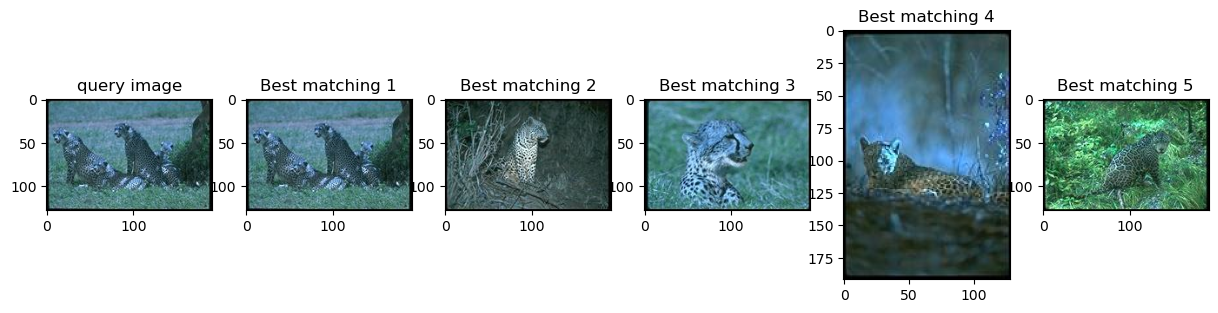

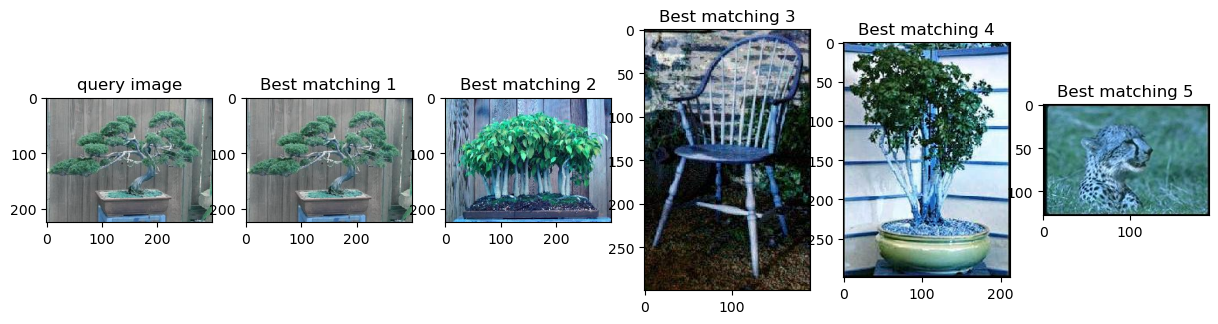

In [6]:
def image_retrieval_tf_idf(query_image_names, k, idf_bow):
    '''
    Inputs:
    query_image_names: a list of names of query images.
    k: vocabulary size, i.e the k categories.
    idf_bow: the IDF regularized BoW matrix of stored images.
    '''
    # Get SIFT descriptors of query images
    query_sift_features = extract_sift_features(query_image_names)
    # Building BoW 
    query_bow = sift_descriptor2bow(query_sift_features, k)
    # TF-IDF
    idf_query_bow = idf_regularization(query_bow)
    print(idf_query_bow.shape)
    # compute cosine similarity between normalized vectors
    scores = np.dot(idf_query_bow, idf_bow.T) 
    return np.argsort(-scores, axis=1)  # sorting matches

def plot_best_matches(query_image_name, total_images_names, ranked_IDs, best_match_numbers = 5):
    '''
    Plot the best N matches of a query image.
    '''
    plt.rcParams['figure.figsize'] = (15.0, 8.0)
    fig, ax = plt.subplots(1, best_match_numbers + 1)
    ax[0].imshow(cv2.imread(query_image_name))
    ax[0].set_title('query image')
    for i, ID in enumerate(ranked_IDs[0:best_match_numbers]):
        ax[i + 1].imshow(cv2.imread(total_images_names[ID]))
        ax[i + 1].set_title(f'Best matching {i + 1}')
    plt.show()

query_image_names = [training_images_names[1], training_images_names[10]]
ranked_IDs = image_retrieval_tf_idf(query_image_names, k, idf_bow)
print(ranked_IDs.shape)
for query_image, ranked_ids in zip(query_image_names, ranked_IDs):
    plot_best_matches(query_image, training_images_names, ranked_ids)


# Evaluation

In [7]:
# The mean reciprocal rank
def get_mean_reciprocal_rank(query_image_names, retrieval_results, name2category, all_image_names):
    labels = [name2category[name] for name in query_image_names]

    rank = np.full(len(labels), np.inf)
    for idx, (label, result) in enumerate(zip(labels, retrieval_results)):
        for i, id in enumerate(result):
            if (name2category.get(all_image_names[id], -1) == label):
                rank[idx] = i + 1
                break

    return np.mean(1.0 / rank), rank

def percentage_of_the_correct_category_in_top3(rank):
    return np.sum((rank<=3) * 1) / len(rank)
# Evaluation
mean_reciprocal_rank, rank = get_mean_reciprocal_rank(query_image_names, ranked_IDs, name2category, training_images_names)
percentage = percentage_of_the_correct_category_in_top3(rank)
print(f'Evaluation of training data: mean reciprocal rank: {mean_reciprocal_rank}, percentage of the correct category in top 3: {percentage* 100}%')


Evaluation of training data: mean reciprocal rank: 1.0, percentage of the correct category in top 3: 100.0%


# Retrieval, second experiment


(462, 200)
(462, 50)


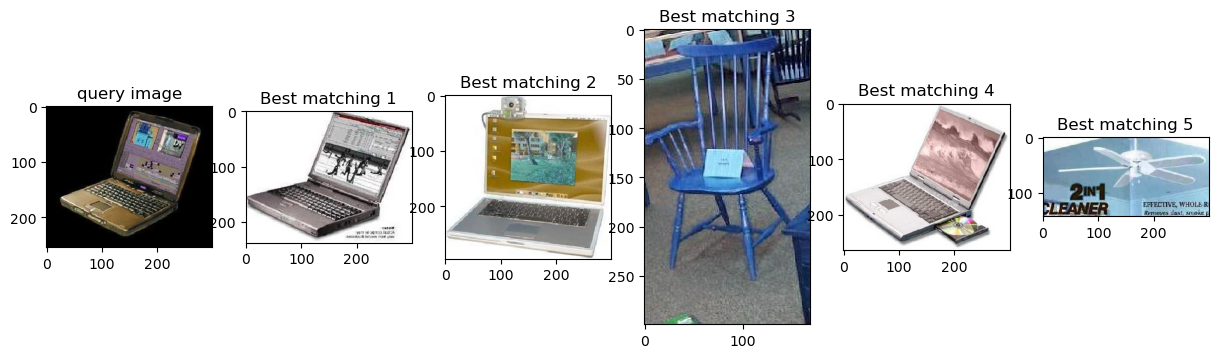

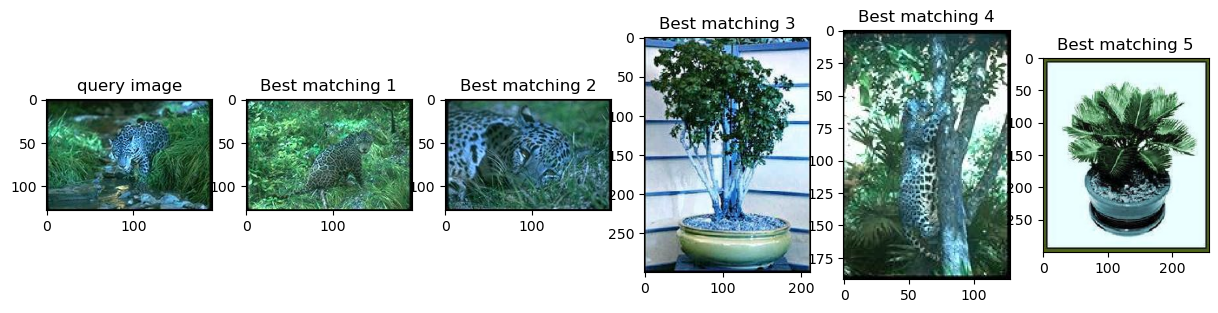

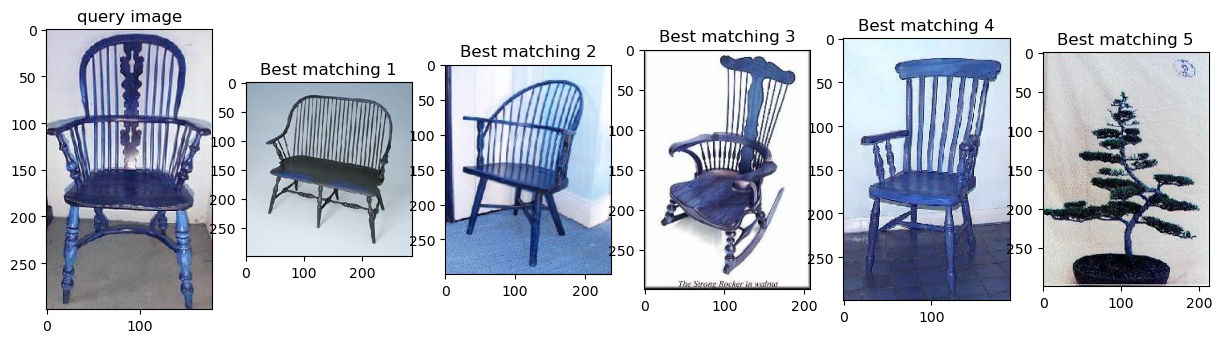

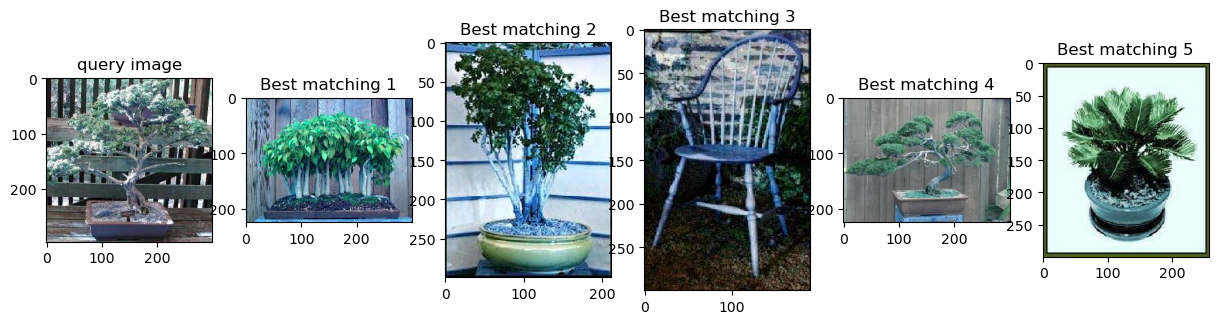

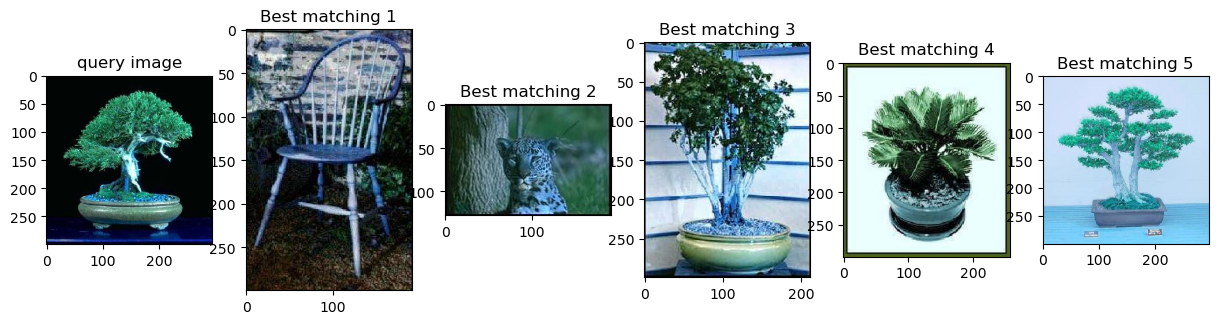

Evaluation of test data: mean reciprocal rank: 0.8388344949126079, percentage of the correct category in top 3: 91.77489177489177%


In [8]:
import random
random.shuffle(test_image_names)
# retrieve images
query_image_names = test_image_names
ranked_IDs = image_retrieval_tf_idf(query_image_names, k, idf_bow)
print(ranked_IDs.shape)
for i, (query_image, ranked_ids) in enumerate(zip(query_image_names, ranked_IDs)):
    if i < 5:
        plot_best_matches(query_image, training_images_names, ranked_ids)

# Evaluation
mean_reciprocal_rank, rank = get_mean_reciprocal_rank(query_image_names, ranked_IDs, name2category, training_images_names)
percentage = percentage_of_the_correct_category_in_top3(rank)
print(f'Evaluation of test data: mean reciprocal rank: {mean_reciprocal_rank}, percentage of the correct category in top 3: {percentage* 100}%')
